In [12]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [13]:
def direct_least_square(x, y):
    D = np.mat(np.vstack([x**2, x*y, y**2, x, y, np.ones(len(x))])).T
    S = np.dot(D.T, D)
    C = np.zeros((6, 6))
    C[0, 2] = 2
    C[1, 1] = -1
    C[2, 0] = 2
    Z = np.dot(np.linalg.inv(S), C)
    eigen_value, eigen_vec = np.linalg.eig(Z)
    eigen_value = eigen_value.reshape(1, -1)
    pos_r, pos_c = np.where(eigen_value>0 & ~np.isinf(eigen_value))
    a = eigen_vec[:, pos_c]
    return a

def ellipse_center(a):
    a = a.reshape(-1, 1)
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    num = b*b-a*c
    x0=(c*d-b*f)/num
    y0=(a*f-b*d)/num
    return (int(y0[0, 0])+1, int(x0[0, 0])+1)

def ellipse_angle_of_rotation(a):
    a = a.reshape(-1, 1)
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    return int(np.rad2deg(0.5*np.arctan(2*b/(a-c))[0, 0]))

def ellipse_axis_length(a):
    a = a.reshape(-1, 1)
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    up = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
    down1=(b*b-a*c)*( (c-a)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    down2=(b*b-a*c)*( (a-c)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    res1=np.sqrt(up/down1)
    res2=np.sqrt(up/down2)
    return (int(res1[0,0]), int(res2[0, 0]))

In [14]:
ellipse = cv2.imread('source.PNG', 0)

x_ellipse, y_ellipse = ellipse.nonzero()
a_ellipse = direct_least_square(x_ellipse, y_ellipse)

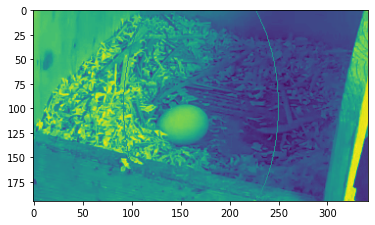

In [15]:
center = ellipse_center(a_ellipse)
axis = ellipse_axis_length(a_ellipse)
angle = ellipse_angle_of_rotation(a_ellipse)
start_angle = 0
end_angle = 360
color = 150
thickness = 1
plt.imshow(cv2.ellipse(ellipse, center, axis, angle, start_angle, end_angle, color, thickness))

In [58]:
w = 0.4
p = 0.75
# we need at least 6 points to estimates 6 parameters of the ellipse

k = np.log(1-p) / np.log(1-np.power(w, 6))
print('Number of needed iterations: {}'.format(int(np.ceil(k))))

Number of needed iterations: 338


In [63]:
import random

def ransac(image, max_iter, threshold=5):
    ellipse_noise = image
    data = ellipse_noise
    ics = []
    best_ic = 0
    best_model = None
    xn, yn = data.nonzero()
    nzero = [(x1,y1) for x1, y1 in zip(xn, yn)]
    for epoch in range(max_iter):
        ic = 0
        sample = random.sample(nzero, 6)
        a = direct_least_square(np.array([s[0] for s in sample]), np.array([s[1] for s in sample]))
        for x, y in sample:
            eq = np.mat(np.vstack([x**2, x*y, y**2, x, y, 1])).T
            if np.abs(np.dot(eq, a.reshape(-1,1))) <= threshold:
                ic += 1
        ics.append(ic)
        if ic > best_ic:
            best_ic = ic
            best_model = a
    return a, ics

ellipse_noise = cv2.imread('source.PNG', 0)
a, _ = ransac(ellipse_noise, 338, 5)

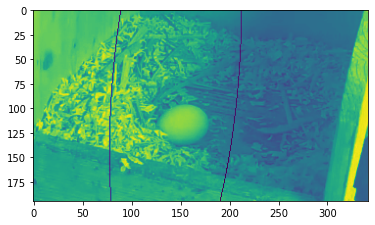

In [64]:
center = ellipse_center(a)
axis = ellipse_axis_length(a)
angle = ellipse_angle_of_rotation(a)
start_angle = 0
end_angle = 360
color = 12
thickness = 1
plt.imshow(cv2.ellipse(ellipse_noise, center, axis, angle, start_angle, end_angle, color, thickness))

In [65]:
import pandas as pd

In [66]:
def segment_fit_ellipse_ransac(seg, centers, fn_preproc_points, nb_inliers=0.6,
                               thr_overlap=SEGM_OVERLAP):
    """ segment eggs using ellipse fitting and RANDSAC strategy

    :param ndarray seg: input image / segmentation
    :param [[int, int]] centers: position of centres / seeds
    :param fn_preproc_points: function for detection boundary points
    :param float nb_inliers: ratio of inliers for RANSAC
    :param float thr_overlap: threshold for removing overlapping segmentations
    :return (ndarray, [[int, int]]): resulting segmentation, updated centres
    """
    points_centers = fn_preproc_points(seg, centers)

    centres_new, ell_params = [], []
    segm = np.zeros_like(seg)
    for i, points in enumerate(points_centers):
        lb = i + 1
        nb_min = int(len(points) * nb_inliers)
        ransac_model, _ = measure.ransac(points, EllipseModel,
                                         min_samples=nb_min,
                                         residual_threshold=15,
                                         max_trials=250)
        if not ransac_model:
            continue
        logging.debug('ellipse params: %r', ransac_model.params)
        segm = ell_fit.add_overlap_ellipse(segm, ransac_model.params, lb,
                                           thr_overlap)

        if np.any(segm == lb):
            centres_new.append(centers[i])
            ell_params.append(ransac_model.params)

    dict_export = {'ellipses.csv': pd.DataFrame(ell_params, columns=COLUMNS_ELLIPSE)}
    return segm, np.array(centres_new), dict_export 

NameError: name 'SEGM_OVERLAP' is not defined